In [17]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn import svm
import seaborn as sns
import random

In [18]:
csv_file_path = 'D:/MACHINE LEARNING/FACE EXPRESSION  DATASET/labels.csv'  
data = pd.read_csv(csv_file_path)

In [19]:
base_image_folder = 'D:/MACHINE LEARNING/FACE EXPRESSION  DATASET/' 

In [20]:
data['full_path'] = data['path'].apply(lambda x: os.path.join(base_image_folder, x))

In [21]:
data['exists'] = data['full_path'].apply(lambda x: os.path.exists(x))

In [22]:
folder_counts = data.groupby(['label', 'exists']).size().unstack(fill_value=0)

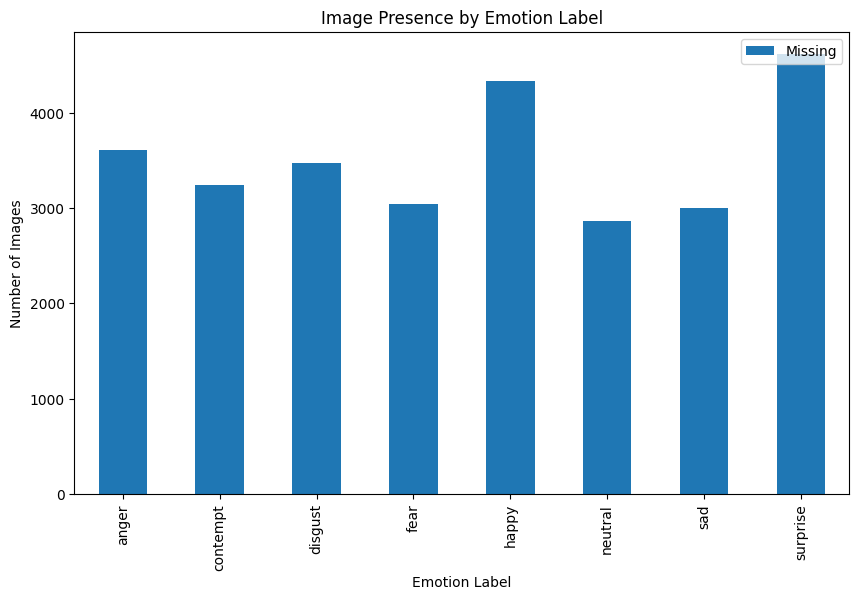

In [23]:
folder_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Image Presence by Emotion Label')
plt.xlabel('Emotion Label')
plt.ylabel('Number of Images')
plt.legend(['Missing', 'Present'], loc='upper right')
plt.show()

In [24]:
data = data[data['exists']]

In [25]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

In [26]:
lb = LabelBinarizer()
train_labels_nn = lb.fit_transform(train_data['label'])
test_labels_nn = lb.transform(test_data['label'])

In [27]:
train_labels_svm = train_data['label']
test_labels_svm = test_data['label']

In [28]:
datagen = ImageDataGenerator(rescale=1./255)

In [29]:
train_gen = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='full_path',
    y_col='label',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='full_path',
    y_col='label',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 19722 validated image filenames belonging to 8 classes.
Found 8453 validated image filenames belonging to 8 classes.


In [30]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(lb.classes_), activation='softmax')
])

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
history = model.fit(train_gen, epochs=10, validation_data=test_gen)

Epoch 1/10
617/617 [==============================] - 299s 483ms/step - loss: 1.7307 - accuracy: 0.3468 - val_loss: 1.5041 - val_accuracy: 0.4356
Epoch 2/10
617/617 [==============================] - 172s 278ms/step - loss: 1.3400 - accuracy: 0.5036 - val_loss: 1.3243 - val_accuracy: 0.5125
Epoch 3/10
617/617 [==============================] - 168s 272ms/step - loss: 1.1693 - accuracy: 0.5681 - val_loss: 1.3003 - val_accuracy: 0.5270
Epoch 4/10
617/617 [==============================] - 167s 271ms/step - loss: 1.0539 - accuracy: 0.6131 - val_loss: 1.2420 - val_accuracy: 0.5522
Epoch 5/10
617/617 [==============================] - 171s 276ms/step - loss: 0.9545 - accuracy: 0.6490 - val_loss: 1.2337 - val_accuracy: 0.5626
Epoch 6/10
617/617 [==============================] - 206s 333ms/step - loss: 0.8604 - accuracy: 0.6856 - val_loss: 1.3204 - val_accuracy: 0.5519
Epoch 7/10
617/617 [==============================] - 196s 317ms/step - loss: 0.7486 - accuracy: 0.7302 - val_loss: 1.3994 -

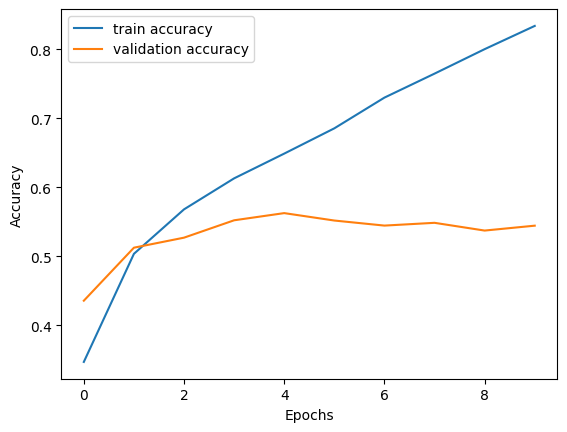

In [33]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
test_loss, test_acc = model.evaluate(test_gen)
print(f'Test accuracy (Neural Network): {test_acc}')

265/265 [==============================] - 18s 67ms/step - loss: 1.8485 - accuracy: 0.5444
Test accuracy (Neural Network): 0.5444220900535583


In [35]:
def plot_predictions(generator, model, lb, num_images=5):
    batch = next(generator)
    images, true_labels = batch[0], batch[1]

    predictions = model.predict(images)

    random_indices = random.sample(range(len(images)), num_images)
    plt.figure(figsize=(12, 8))
    
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        
        predicted_label = lb.classes_[np.argmax(predictions[idx])]
        true_label = lb.classes_[np.argmax(true_labels[idx])]
        
        plt.title(f'True: {true_label}\nPred: {predicted_label}')
        plt.axis('off')
    
    plt.show()

1/1 [==============================] - 0s 166ms/step


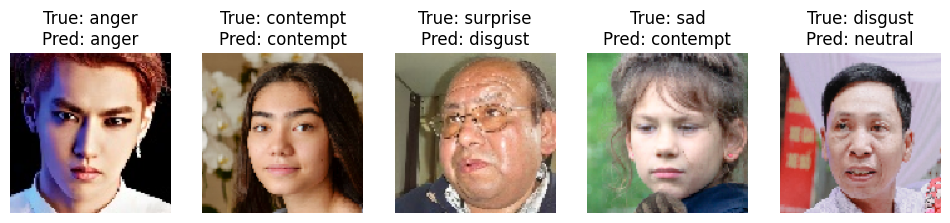

In [36]:
plot_predictions(test_gen, model, lb)

In [37]:
def extract_features(data, model):
    features = []
    for img_path in data['full_path']:
        img_array = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
        img_array = tf.keras.preprocessing.image.img_to_array(img_array)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        feature = model.predict(img_array)
        features.append(feature.flatten())
    return np.array(features)

In [38]:
feature_extractor = models.Model(inputs=model.input, outputs=model.layers[-2].output)

In [39]:
def extract_features_batch(generator, model, batch_size=32):
    """
    Extract features using batches to speed up the process.
    Args:
        generator: Image data generator.
        model: Feature extraction model.
        batch_size: Number of images to process per batch.
    Returns:
        Numpy array of extracted features.
    """
    features = []
    labels = []
    
    for batch_images, batch_labels in generator:
        batch_features = model.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels)
        
        if len(features) * batch_size >= generator.n:
            break

    return np.vstack(features), np.vstack(labels)

train_features, train_labels_nn = extract_features_batch(train_gen, feature_extractor)
test_features, test_labels_nn = extract_features_batch(test_gen, feature_extractor)

1/1 [==============================] - 0s 70ms/step


In [40]:
train_labels_svm = lb.inverse_transform(train_labels_nn)
test_labels_svm = lb.inverse_transform(test_labels_nn)

In [41]:
svm_model = svm.SVC(kernel='linear')
svm_model.fit(train_features, train_labels_svm)

SVC(kernel='linear')

In [42]:
svm_predictions = svm_model.predict(test_features)
svm_accuracy = accuracy_score(test_labels_svm, svm_predictions)
print(f'Test accuracy (SVM): {svm_accuracy}')

Test accuracy (SVM): 0.5430024843250917


In [43]:
print('Classification Report (SVM):')
print(classification_report(test_labels_svm, svm_predictions))

Classification Report (SVM):
              precision    recall  f1-score   support

       anger       0.49      0.48      0.49      1076
    contempt       0.51      0.55      0.53       936
     disgust       0.45      0.46      0.46      1028
        fear       0.53      0.52      0.53       909
       happy       0.81      0.80      0.80      1326
     neutral       0.45      0.42      0.43       899
         sad       0.43      0.44      0.44       900
    surprise       0.56      0.56      0.56      1379

    accuracy                           0.54      8453
   macro avg       0.53      0.53      0.53      8453
weighted avg       0.54      0.54      0.54      8453



In [44]:
svm_model = svm.SVC(kernel='linear')
svm_model.fit(train_features, train_labels_svm)

SVC(kernel='linear')

In [45]:
svm_predictions = svm_model.predict(test_features)
svm_accuracy = accuracy_score(test_labels_svm, svm_predictions)
print(f'Test accuracy (SVM): {svm_accuracy}')

Test accuracy (SVM): 0.5430024843250917


In [46]:
print('Classification Report (SVM):')
print(classification_report(test_labels_svm, svm_predictions))

Classification Report (SVM):
              precision    recall  f1-score   support

       anger       0.49      0.48      0.49      1076
    contempt       0.51      0.55      0.53       936
     disgust       0.45      0.46      0.46      1028
        fear       0.53      0.52      0.53       909
       happy       0.81      0.80      0.80      1326
     neutral       0.45      0.42      0.43       899
         sad       0.43      0.44      0.44       900
    surprise       0.56      0.56      0.56      1379

    accuracy                           0.54      8453
   macro avg       0.53      0.53      0.53      8453
weighted avg       0.54      0.54      0.54      8453

